# ETL Project - Alaska Real Estate Properties (multi-family units) 

#### Gathering spatial and non-spatial data on properties in Anchorage, Alaska, storing the data in PostgreSQL database and running SQL queries with python and the PostgreSQL connection to understand distribution of properties across the city.

-----

##### import packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import os
import requests

#database connection
import psycopg2
import psycopg2.extras #saves output into dict

#geospatial packages
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString, Polygon
import contextily as ctx
import pyproj
from shapely import wkb
from shapely import wkt
import osgeo.ogr

# postgres password info
from postgres_keys import postgres_key

### The focus of this project is to ensure proper loading of GIS data into Posgres database (using PostGIS functionality), querying the stored data, and accessing it in Python for spatial analysis.

### Main Processing Steps

#### PostgreSQL Database
1. set up PostGIS and spatial extensions within the database

#### Installing libraries
1. geopandas - geo dataframe
2. shapely - geometry
3. contextily - viewing basemaps
4. osgeo/gdal open source geospatial, GDAL translator library for raster and vector geospatial data formats 

#### GIS
1. import shapefile
2. convert geometry from WKT format into PostGIS format for database storage
3. query centroids (center of polygons to get points)
4. convert WKB PostGIS format back into WKT format for mapping

#### GIS Data - shapefiles
1. Fire Stations
2. property info (spatial)
3. property info (non-spatial)
4. census tracts
5. census tract rental pricing (2015 data)
6. census tract median income (2015 data)

### ER Diagram

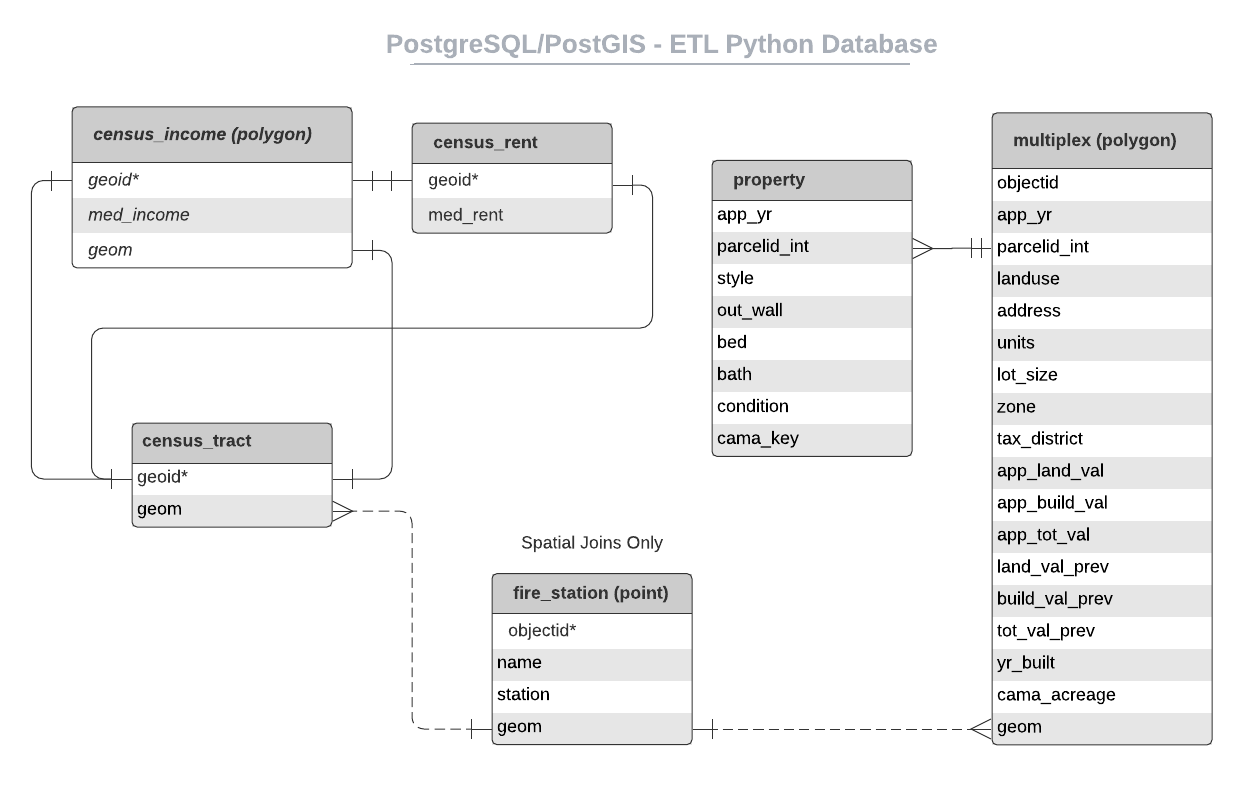

## Create Postgres Tables

##### postgres connection information

In [3]:
#store the assess info
host = 'localhost'
database = 'postgis_db'
user = 'postgres'
password = postgres_key

##### Create Residential Property table (non-spatial)

In [81]:
#setting these to ensure database/cursor connection will close at end
conn = None
cur = None

try:
    # connecting to the database
    conn = psycopg2.connect(host=host, database=database, user=user, password=postgres_key)
    #open cursor
    cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor) #returns output as dict
    
#Property Data - Residential Properties with Details
       
    #to avoid errors due to overwrite in script execution
    cur.execute('DROP TABLE IF EXISTS property')
    
    #create table script
    create_script = ''' CREATE TABLE IF NOT EXISTS property (
                        app_yr int,
                        parcelid varchar(20),
                        style varchar(20),
                        out_wall varchar(15),
                        bed int,
                        bath int,
                        condition varchar(15),
                        cama_key varchar(22),
                        parcelid_int bigint)'''

    #execute create table
    cur.execute(create_script)
      
    #First delete the existing contents of this table in case we want to run the code multiple times.
    cur.execute("DELETE FROM property")

    with open('CAMA_RES.csv', 'r') as prop:
        next(prop) #no header needed
        cur.copy_from(prop, 'property', sep=',',null='')

    #commit change
    conn.commit()
        
    # closing the connection and cursor
    cur.close()
    conn.close()

except Exception as error:
    print(error)
    
finally:
    # closing the connection and cursor, if problems arise in try block
    if cur is not None:
        cur.close()
    if conn is not None:
        conn.close()

## Create Spatial GIS PostgreSQL/PostGIS tables

##### Create Fire Station location table

In [12]:
#setting these to ensure database/cursor connection will close at end
conn = None
cur = None

try:
    # connecting to the database
    conn = psycopg2.connect(host=host, database=database, user=user, password=postgres_key)
    #open cursor
    cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor) #returns output as dict
    
#FIRE STATIONS - - SPATIAL DATA
       
    #to avoid errors due to overwrite in script execution
    cur.execute('DROP TABLE IF EXISTS fire_station')
    
    #create table script
    create_script = ''' CREATE TABLE IF NOT EXISTS fire_station (
                        objectid SERIAL PRIMARY KEY,
                        name varchar(40),
                        station int,
                        geom geography) '''
    
    #execute script with cursor
    cur.execute(create_script)
      
    #from http://andrewgaidus.com/Build_Query_Spatial_Database/
    shapefile = osgeo.ogr.Open("FireStations_Hosted.shp")
    layer = shapefile.GetLayer(0)

    #create a spatial index for the outline field, which is necessary to make efficient spatial queries
    cur.execute("CREATE INDEX fire_index ON fire_station USING GIST(geom)")
       
    #First delete the existing contents of this table in case we want to run the code multiple times.
    cur.execute("DELETE FROM fire_station")
    
    #loop through the file and insert
    for i in range(layer.GetFeatureCount()):
        feature = layer.GetFeature(i)
        objectid = feature.GetField("OBJECTID")
        name = feature.GetField("NAME")
        station = feature.GetField("STATION_NU")
        #Get feature geometry
        geometry = feature.GetGeometryRef()
        #Convert geometry to WKT format
        wkt = geometry.ExportToWkt()
        #Insert data into database, converting WKT geometry to a PostGIS geography
        cur.execute("INSERT INTO fire_station (objectid,name,station,geom) VALUES ({},'{}',{}, ST_GeogFromText('{}'))".format(objectid,name,station,wkt))
      
    #commit change
    conn.commit()
        
    # closing the connection and cursor
    cur.close()
    conn.close()

except Exception as error:
    print(error)
    
finally:
    # closing the connection and cursor, if problems arise in try block
    if cur is not None:
        cur.close()
    if conn is not None:
        conn.close()


##### Create Census Income, Census Tract, and Census Rent

In [46]:
conn = None
cur = None

try:
    conn = psycopg2.connect(host=host, database=database, user=user, password=postgres_key)
    cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor) 


########################################################################################################
#CENSUS INCOME
########################################################################################################
    cur.execute('DROP TABLE IF EXISTS census_income')
    
    create_script = ''' CREATE TABLE IF NOT EXISTS census_income (
                        geoid bigint,
                        med_income int,
                        geom geography) '''

    cur.execute(create_script)
    
    shapefile2 = osgeo.ogr.Open("Census_Income.shp")
    layer = shapefile2.GetLayer(0)
    
    #cur.execute("CREATE INDEX income_index ON census_income USING GIST(geom)")
    cur.execute("DELETE FROM census_income")
    
    for i in range(layer.GetFeatureCount()):
        feature = layer.GetFeature(i)
        geoid = feature.GetField("Id2")
        med_income = feature.GetField("Estimate")
        geometry = feature.GetGeometryRef()
        wkt = geometry.ExportToWkt()
        cur.execute("INSERT INTO census_income (geoid,med_income,geom) VALUES ({},{}, ST_GeogFromText('{}'))".format(geoid,med_income,wkt))

########################################################################################################
#CENSUS TRACT (matches income, rents)
########################################################################################################
    cur.execute('DROP TABLE IF EXISTS census_tract')
    
    create_script = ''' CREATE TABLE IF NOT EXISTS census_tract (
                        geoid bigint,
                        geom geography) '''

    cur.execute(create_script)
    
    shapefile2 = osgeo.ogr.Open("census_tract.shp")
    layer = shapefile2.GetLayer(0)
    
    cur.execute("CREATE INDEX tract_index ON census_tract USING GIST(geom)")
    cur.execute("DELETE FROM census_tract")
    
    for i in range(layer.GetFeatureCount()):
        feature = layer.GetFeature(i)
        geoid = feature.GetField("geoid")
        geometry = feature.GetGeometryRef()
        wkt = geometry.ExportToWkt()
        cur.execute("INSERT INTO census_tract (geoid,geom) VALUES ({}, ST_GeogFromText('{}'))".format(geoid,wkt))
        
########################################################################################################
#CENSUS RENT - no spatial data even though it has geometry
########################################################################################################
    #to avoid errors due to overwrite in script execution
    cur.execute('DROP TABLE IF EXISTS census_rent')
    
    #create table script
    create_script = ''' CREATE TABLE IF NOT EXISTS census_rent (
                        geoid bigint,
                        med_rent int) '''

    #execute create table
    cur.execute(create_script)
      
    #First delete the existing contents of this table in case we want to run the code multiple times.
    cur.execute("DELETE FROM census_rent")

    with open('Census_Gross_Rent.csv', 'r') as rent:
        next(rent) #no header needed
        cur.copy_from(rent, 'census_rent', sep=',',null='')
 
    conn.commit()
        
    cur.close()
    conn.close()

except Exception as error:
    print(error)
    
finally:
    # closing the connection and cursor, if problems arise in try block
    if cur is not None:
        cur.close()
    if conn is not None:
        conn.close()

##### Residential Data (Polygons)

In [74]:
host = 'localhost'
database = 'postgis_db'
user = 'postgres'
password = postgres_key

conn = None
cur = None

try:
    conn = psycopg2.connect(
        host=host, 
        database=database, 
        user=user, 
        password=postgres_key)

    cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor) 
    
    cur.execute('DROP TABLE IF EXISTS multiplex')
    
    create_script = ''' CREATE TABLE IF NOT EXISTS multiplex (
                        objectid int primary key,
                        app_yr int,
                        parcelid varchar(20),
                        parcelid_int bigint,
                        landuse varchar(40),
                        address varchar(45),
                        units int,
                        lot_size int,
                        zone varchar(10),
                        tax_district varchar(3),
                        app_land_val int,
                        app_build_val int,
                        app_tot_val int,
                        land_val_prev int,
                        build_val_prev int,
                        tot_val_prev int,
                        yr_built int,
                        cama_acreage double precision,
                        geom geography)'''

    cur.execute(create_script)
    
    #unique for csv for residential properties file
    
    shapefile = osgeo.ogr.Open("PropertyInformation_Hosted.shp")
    layer = shapefile.GetLayer(0)
  
    #cur.execute("CREATE INDEX plex_index ON multiplex USING GIST(geom)")

    cur.execute("DELETE FROM multiplex")

    for i in range(layer.GetFeatureCount()):
        feature = layer.GetFeature(i)
        objectid = feature.GetField("OBJECTID")
        app_yr = feature.GetField("Appraisal_")
        parcelid = feature.GetField("Parcel_ID")
        parcelid_int = feature.GetField("Parcel_ID")
        landuse = feature.GetField("Land_Use") 
        address = feature.GetField("Parcel_Add")
        units = feature.GetField("Total_Livi")
        lot_size = feature.GetField("Lot_Size")
        zone = feature.GetField("Zoning_Dis")
        tax_district = feature.GetField("Tax_Distri")
        app_land_val = feature.GetField("Appraised_")
        app_build_val = feature.GetField("Appraise_1")
        app_tot_val = feature.GetField("Appraise_2")
        land_val_prev = feature.GetField("Land_Value")
        build_val_prev = feature.GetField("Building_V")
        tot_val_prev = feature.GetField("Total_Valu")
        yr_built = feature.GetField("YearBuilt_")
        cama_acreage = feature.GetField("CAMA_Acrea")
        geometry = feature.GetGeometryRef()
        wkt = geometry.ExportToWkt()
        
        cur.execute("INSERT INTO multiplex (objectid,app_yr,parcelid,parcelid_int,landuse,address,units,lot_size,zone,tax_district,app_land_val, app_build_val, app_tot_val,land_val_prev, build_val_prev,tot_val_prev,yr_built,cama_acreage,geom) VALUES ({},{},'{}',{},'{}','{}',{},{},'{}','{}',{},{},{},{},{},{},'{}',{}, ST_GeogFromText('{}'))".format(objectid,app_yr,parcelid,parcelid_int,landuse,address,units,lot_size,zone,tax_district,app_land_val,app_build_val, app_tot_val,land_val_prev, build_val_prev,tot_val_prev,yr_built,cama_acreage,wkt))          
           
    conn.commit()
        
    cur.close()
    conn.close()

except Exception as error:
    print(error)
    
finally:
    # closing the connection and cursor, if problems arise in try block
    if cur is not None:
        cur.close()
    if conn is not None:
        conn.close()

## Queries

##### query 1 - join

Where are the multiplex properties located spatially and which census tract do they belong?

* converted parcel polygon to centroid (point)
* intersected census tract and properties

Result:  The multiplex properties are spread throughout the Anchorage area, but there appears to be some clustering.  Perhaps the areas without properties are commercial or industrial areas within the city and residental property types are not allowed in those zoning areas.

In [17]:
#multiplex distribution across Anchorage
conn = None
cur = None

try:
    conn = psycopg2.connect(host=host, database=database, user=user,password=postgres_key)
    cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor) 
    query1 = '''select landuse, count(landuse) as count, ST_AsText(ST_Centroid(m.geom)) as centroid, c.geom
                from multiplex as m
                join property as p
                on m.parcelid_int = p.parcelid_int
                join census_tract as c
                on ST_Intersects(c.geom, m.geom)
                group by landuse, m.geom, c.geom; '''
    
    plex_in_census = pd.read_sql_query(query1,conn)
 
    conn.commit()  
    cur.close()
    conn.close()

except Exception as error:
    print(error)
    
finally:
    # closing the connection and cursor, if problems arise in try block
    if cur is not None:
        cur.close()
    if conn is not None:
        conn.close()

In [28]:
plex_in_census['coords'] = gpd.GeoSeries.from_wkt(plex_in_census['centroid'])
plex_in_census['census_coords'] = gpd.GeoSeries.from_wkb(plex_in_census['geom'])
plex_in_census_gdf = gpd.GeoDataFrame(plex_in_census,geometry='coords',crs='epsg:4326')
plex_in_census_poly_gdf = gpd.GeoDataFrame(plex_in_census,geometry='census_coords',crs='epsg:4326')
plex_in_census_gdf.head(2)

,landuse,count,centroid,geom,coords,census_coords
0,Duplex,1,POINT(-149.72421532159515 61.218291234356),0103000020E61000000100000008000000B6F3FDD478B7...,POINT (-149.72422 61.21829),"POLYGON ((-149.73350 61.22056, -149.72601 61.2..."
1,Duplex,1,POINT(-149.72421487868434 61.2180923731851),0103000020E61000000100000008000000B6F3FDD478B7...,POINT (-149.72421 61.21809),"POLYGON ((-149.73350 61.22056, -149.72601 61.2..."


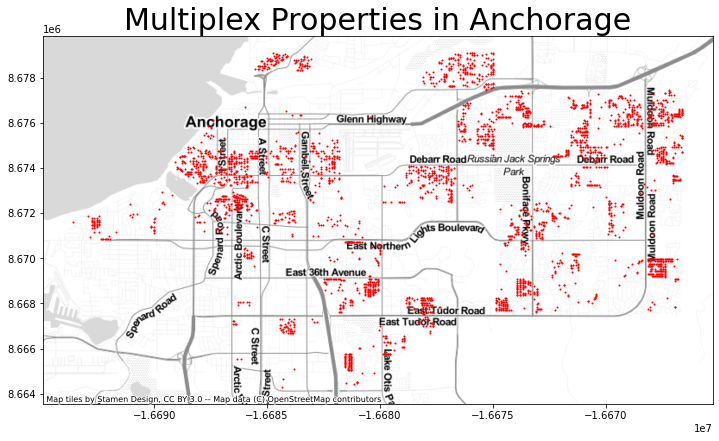

In [56]:
ax = plex_in_census_gdf.to_crs('EPSG:3857').plot(figsize=(12,12), markersize = 1,color='red')
ctx.add_basemap(ax, zoom=12,source=ctx.providers.Stamen.TonerLite)
ax.set_title('Multiplex Properties in Anchorage', fontsize=30)
plt.show()

##### Query 2 - Join

Which census tracts have median income greater than 150,000 (based on ACS 2015 survey)?

* converting WKB (PostGIS geo format) to WKT for mapping
* joining census tract (spatial data only) with census income (data)

Result: Most of the higher income areas are away from city center, and are either coastal or in the eastern mountains.

In [36]:
conn = None
cur = None

try:
    conn = psycopg2.connect(host=host, database=database, user=user,password=postgres_key)
    cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor) 
    query2 = '''select i.med_income, t.geom
                from census_tract as t
                join census_income i
                on t.geoid = i.geoid
                where i.med_income >150000; '''
    high_income = pd.read_sql_query(query2,conn)
    
    conn.commit()
        
    cur.close()
    conn.close()

except Exception as error:
    print(error)
    
finally:
    # closing the connection and cursor, if problems arise in try block
    if cur is not None:
        cur.close()
    if conn is not None:
        conn.close()

In [37]:
high_income['coords'] = gpd.GeoSeries.from_wkb(high_income['geom'])
high_income_gdf = gpd.GeoDataFrame(high_income,geometry='coords',crs='epsg:4326')
high_income_gdf.head(2)

,med_income,geom,coords
0,166667,0103000020E6100000010000000A00000082FFAD64C7B8...,"POLYGON ((-149.77434 61.10966, -149.77438 61.1..."
1,154079,0103000020E6100000010000003E000000D4EFC2D6ECB7...,"POLYGON ((-149.74766 61.12307, -149.74452 61.1..."


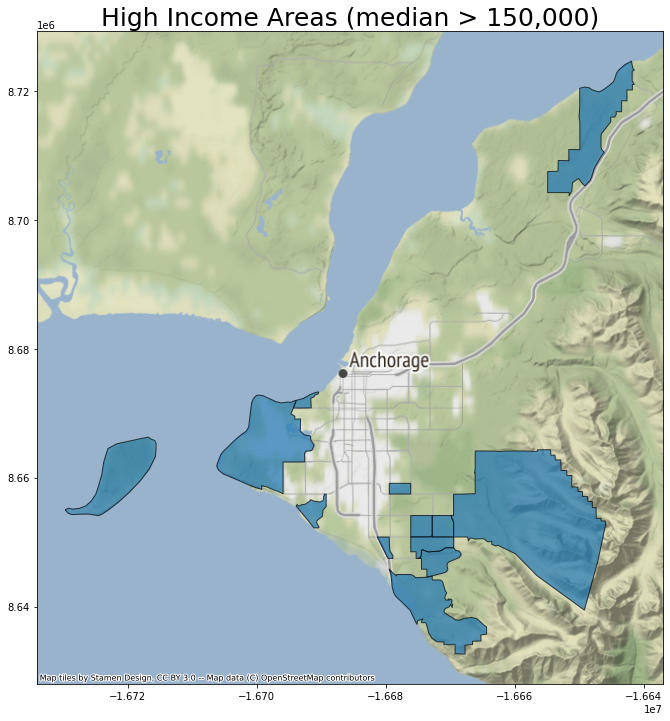

In [44]:
ax = high_income_gdf.to_crs('EPSG:3857').plot(figsize=(12,12),alpha=0.7, edgecolor='k')
ctx.add_basemap(ax, zoom=10)
ax.set_title('High Income Areas (median > 150,000)', fontsize=25)
plt.show()

##### query 3
In what condition are most of the buildings, which property condition is the most common?

In [94]:
conn = None
cur = None

try:
    conn = psycopg2.connect(host=host, database=database, user=user,password=postgres_key)
    cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor) 
    query3 = '''select condition, count(condition)
                from property
                group by condition; '''
    building_condition = pd.read_sql_query(query3,conn)
 
    conn.commit()  
    cur.close()
    conn.close()

except Exception as error:
    print(error)
    
finally:
    # closing the connection and cursor, if problems arise in try block
    if cur is not None:
        cur.close()
    if conn is not None:
        conn.close()

In [96]:
building_condition

,condition,count
0,Average,5997
1,Fair Plus,51
2,Fair Minus,27
3,Poor Minus,28
4,Fair,25
5,Average Minus,83
6,Poor,10
7,Poor Plus,17


##### query 4 - join
What is the distribution of the multiplexes that were built after 2010?

Result:  There doesn't appear to be a spatial trend for newer buildings, as the properties are spread across the city.

In [38]:
conn = None
cur = None

try:
    conn = psycopg2.connect(host=host, database=database, user=user,password=postgres_key)
    cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor) 
    query4 = '''select m.yr_built,p.condition, m.units, m.landuse,m.geom, ST_AsText(ST_Centroid(m.geom)) as centroid
                from property as p
                join multiplex as m
                on p.parcelid_int = m.parcelid_int
                where m.yr_built >2010; '''
    build_2010_cent = pd.read_sql_query(query4,conn)
    
    conn.commit()
        
    cur.close()
    conn.close()

except Exception as error:
    print(error)
    
finally:
    # closing the connection and cursor, if problems arise in try block
    if cur is not None:
        cur.close()
    if conn is not None:
        conn.close()

In [39]:
build_2010_cent['coords'] = gpd.GeoSeries.from_wkt(build_2010_cent['centroid'])
build_2010_cent_gdf = gpd.GeoDataFrame(build_2010_cent,geometry='coords',crs='epsg:4326')
build_2010_cent_gdf.head(2)

,yr_built,condition,units,landuse,geom,centroid,coords
0,2014,Average,1,Single Family w/ Accessory Dwelling Unit,0103000020E61000000100000005000000FC86BDE047BD...,POINT(-149.91541640762443 61.212796492567406),POINT (-149.91542 61.21280)
1,2017,Average,1,Single Family w/ Accessory Dwelling Unit,0103000020E6100000010000000900000010D03CB707BD...,POINT(-149.90741318939934 61.212274577994435),POINT (-149.90741 61.21227)


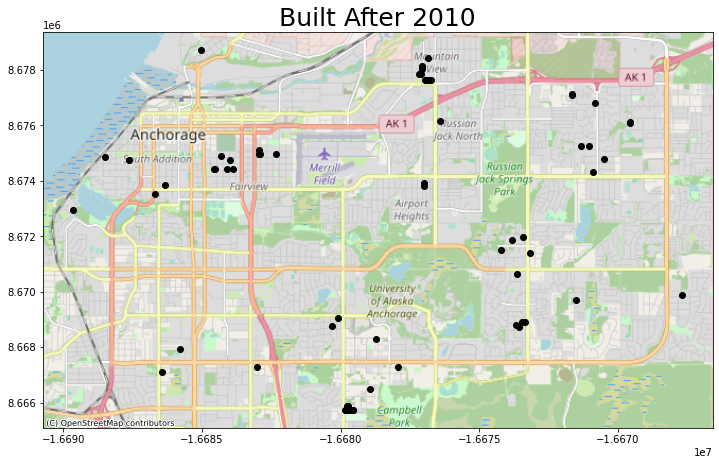

In [43]:
ax = build_2010_cent_gdf.to_crs('EPSG:3857').plot(figsize=(12,12), color='black')
ctx.add_basemap(ax, zoom=12,source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title('Built After 2010', fontsize=25)
plt.show()

##### query 5 - join
Where are rents > 2000, by census tract?

Result: Similar to the higher income census tracts, it appears that rents are higher in the surrounding area rather than in the city center.

In [49]:
conn = None
cur = None

try:
    conn = psycopg2.connect(host=host, database=database, user=user,password=postgres_key)
    cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor) 
    query5 = '''select r.med_rent, t.geom
                from census_tract as t
                join census_rent r
                on t.geoid = r.geoid
                where r.med_rent >2000; '''
    rent_2000 = pd.read_sql_query(query5,conn)
    
    conn.commit()
        
    cur.close()
    conn.close()

except Exception as error:
    print(error)
    
finally:
    # closing the connection and cursor, if problems arise in try block
    if cur is not None:
        cur.close()
    if conn is not None:
        conn.close()

In [51]:
rent_2000['coords'] = gpd.GeoSeries.from_wkb(rent_2000['geom'])
rent_2000_gdf = gpd.GeoDataFrame(rent_2000,geometry='coords',crs='epsg:4326')
rent_2000_gdf.head(2)

,med_rent,geom,coords
0,2070,0103000020E61000000100000008000000DA1EBDE13EB1...,"POLYGON ((-149.53893 61.31548, -149.53391 61.3..."
1,2219,0103000020E61000000100000015000000E9BE377B0EBE...,"POLYGON ((-149.93927 61.11479, -149.93232 61.1..."


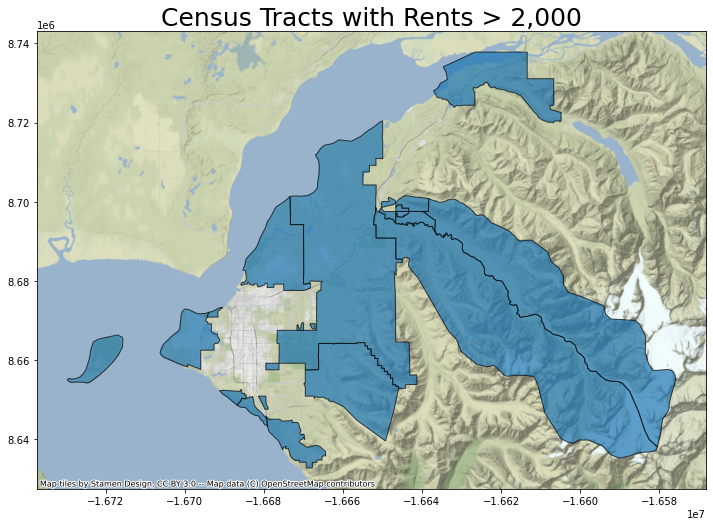

In [52]:
ax = rent_2000_gdf.to_crs('EPSG:3857').plot(figsize=(12,12), alpha=0.7, edgecolor='k')
ctx.add_basemap(ax, zoom=12)
ax.set_title('Census Tracts with Rents > 2,000', fontsize=25)
plt.show()

##### query 6 - join
What are the property value changes from previous appraisal to current appraisal value by multiplex type?

Result: Duplexes are the most common, but lost the most in value, followed by Triplexes (which also lost value when added together).  Single family homes with Accessory Dwelling Units (i.e. "Mother-in-law" units) were the only properties to show an increase in property value (based on appraisals), but they are fairly uncommon (5% of table counts).

In [53]:
conn = None
cur = None

try:
    conn = psycopg2.connect(host=host, database=database, user=user,password=postgres_key)
    cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor) 
    query6 = '''select landuse, sum(app_tot_val - tot_val_prev) as val_gain, count(landuse)
                from multiplex as m
                join property as p
                on m.parcelid_int = p.parcelid_int
                where style is not NULL 
                group by landuse
                order by sum(app_tot_val - tot_val_prev) DESC; '''
    value_change = pd.read_sql_query(query6,conn)
    
    conn.commit()
        
    cur.close()
    conn.close()

except Exception as error:
    print(error)
    
finally:
    # closing the connection and cursor, if problems arise in try block
    if cur is not None:
        cur.close()
    if conn is not None:
        conn.close()

In [54]:
value_change

,landuse,val_gain,count
0,Single Family w/ Accessory Dwelling Unit,116300,147
1,Triplex,-294300,381
2,Duplex,-9048100,2611
